In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Import Label Encoder
from sklearn import preprocessing
# Import Train Test Split
# from sklearn.model_selection import train_test_split
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
# Import GaussianNB
from sklearn.naive_bayes import GaussianNB
# Import
from sklearn import metrics
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
# Import cross_val_score
from sklearn.model_selection import cross_val_score
# Import confusion_matrix
from sklearn.metrics import confusion_matrix
# Import classification_report
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('weather-2021-preprocessed.csv')

# PHẦN 2: MÔ HÌNH HÓA DỮ LIỆU

## A. Mô hình hóa dữ liệu

### Giới thiệu bài toán
Dựa trên việc tìm hiểu về bộ dữ liệu thông qua các quá trình Khám phá dữ liệu và Đặt các câu hỏi có ý nghĩa cần trả lời, bài toán thích hợp cho bộ dữ liệu này là **'Dự đoán điều kiện thời tiết là nhiều mây hay không?'**.

Bài toán được chọn do bộ dữ liệu có các thuộc tính biểu thị chỉ số khí hậu (numerical columns) tương ứng với cột điều kiện thời tiết (categorical column). Tuy nhiên, ở cột điều kiện thời tiết, giá trị `Cloudy` chiếm nhiều hơn hẳn các giá trị còn lại, nên việc bài toán dự đoán là nhiều mây (`Cloudy`) hay không (các trường hợp còn lại) sẽ phù hợp và tránh trường hợp dữ liệu bị lệch (biased) gây ảnh hưởng đến hiệu suất của mô hình.

### Lựa chọn thuật toán máy học

Lý do lựa chọn thuật toán phân lớp (Classification Algorithm)
- Phân lớp (classification) là một tiến trình xử lý nhằm xếp các mẫu dữ liệu hay các đối tượng vào một trong các lớp đã được định nghĩa trước. Các mẫu dữ liệu hay các đối tượng được xếp về các lớp dựa vào giá trị của các thuộc tính (attributes) của mẫu dữ liệu hay đối tượng đó. Sau khi đã xếp tất cả các đối tượng đã biết trước vào các lớp tương ứng, lúc này mỗi lớp được đặc trưng bởi tập các thuộc tính của các đối tượng chứa trong lớp đó.
- Về bài toán "Dự đoán điều kiện thời tiết là nhiều mây hay không?", ở đây ta có 2 loại dữ liệu "có mây" và "không mây". Vì thế chọn Classification Algorithm là phù hợp nhất

### Phân tích, lựa chọn những đặc trưng có mức độ liên quan cao, có tính quan trọng cho bài toán và tiền xử lý

Như đã trình bày ở Giới thiệu bài toán, ta tiến hành thay đổi tập giá trị ở cột `Condition`.

In [3]:
condition = {'Cloudy':'Cloudy',
             'Fair':'Not Cloudy',
             'Rain':'Not Cloudy',
             'Fog / Haze':'Not Cloudy',
             'T-Storm':'Not Cloudy',
             'Thunder':'Not Cloudy'}

df['Condition'] = df['Condition'].map(condition)
set(df['Condition'].to_list())

{'Cloudy', 'Not Cloudy'}

Từ quá trình đặt các câu hỏi có ý nghĩa cần trả lời, ta nhận thấy khác tháng trong năm có mối quan hệ nhất định với các biến thời tiết và điều kiện thời tiết, nên ở cột `Time` ta chỉ lấy tháng.

In [4]:
df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = df['Time'].dt.month
df

,Time,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Description,UV Index,Condition
0,1,75,75.0,75.0,61.0,61.0,6.0,8,29.85,Low,0,Cloudy
1,1,75,75.0,75.0,61.0,61.0,6.0,7,29.85,Low,0,Cloudy
2,1,75,75.0,75.0,61.0,61.0,6.0,7,29.82,Low,0,Cloudy
3,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,Low,0,Cloudy
4,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,Low,0,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...
17385,12,81,82.0,82.0,64.0,58.0,6.0,8,29.94,Low,0,Cloudy
17386,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,Low,0,Cloudy
17387,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,Low,0,Cloudy
17388,12,79,81.0,81.0,64.0,61.0,6.0,8,29.94,Low,0,Cloudy


Từ quá trình đặt các câu hỏi có ý nghĩa cần trả lời, ta nhận thấy `UV Description` và `UV Index` có mức độ tương quan nhất định, chỉ số UV có thể biểu thị cho mức độ UV nên việc có cột `UV Description` trong quá trình này là không cần thiết.

In [5]:
df = df.drop('UV Description', axis=1)
df

,Time,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Index,Condition
0,1,75,75.0,75.0,61.0,61.0,6.0,8,29.85,0,Cloudy
1,1,75,75.0,75.0,61.0,61.0,6.0,7,29.85,0,Cloudy
2,1,75,75.0,75.0,61.0,61.0,6.0,7,29.82,0,Cloudy
3,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,0,Cloudy
4,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,0,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...
17385,12,81,82.0,82.0,64.0,58.0,6.0,8,29.94,0,Cloudy
17386,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,0,Cloudy
17387,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,0,Cloudy
17388,12,79,81.0,81.0,64.0,61.0,6.0,8,29.94,0,Cloudy


Cột `Condition` là dạng categorical nên trước khi đưa vào mô hình, ta phải đưa về dạng numerical.

In [6]:
# Tạo Label Encoder
le = preprocessing.LabelEncoder()
# Chuyển các chuỗi label thành số
df['Condition'] = le.fit_transform(df['Condition'])
df

,Time,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Index,Condition
0,1,75,75.0,75.0,61.0,61.0,6.0,8,29.85,0,0
1,1,75,75.0,75.0,61.0,61.0,6.0,7,29.85,0,0
2,1,75,75.0,75.0,61.0,61.0,6.0,7,29.82,0,0
3,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,0,0
4,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,0,0
...,...,...,...,...,...,...,...,...,...,...,...
17385,12,81,82.0,82.0,64.0,58.0,6.0,8,29.94,0,0
17386,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,0,0
17387,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,0,0
17388,12,79,81.0,81.0,64.0,61.0,6.0,8,29.94,0,0


## B. Huấn luyện và đánh giá mô hình

Tách tập dữ liệu thành feature và label.

In [7]:
X = df[['Time', 'Temperature', 'Heat Index', 'Temperature Feels Like', 'Dew Point', 'Humidity', 'Wind Force', 'Wind Speed', 'Pressure', 'UV Index']]
y = df['Condition']

Tách tập dữ liệu thành tập huấn luyện (training set) và tập kiểm tra (test set).

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

X_train = X.iloc[:13042]
X_test = X.iloc[13042:17390]
y_train = y[:13042]
y_test = y[13042:17390]

print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (13042, 10) (13042,)
Testing set shape:  (4348, 10) (4348,)


Sau khi đã tách tập dữ liệu thành tập huấn luyện và tập kiểm tra, ta sẵn sàng tiến hành huấn luyện và đánh giá mô hình với hai mô hình phổ biến cho các phân lớp, đó chính là KNN và Naive Bayes.

### KNN Classification
KNN (K-nearest neighbor) là một trong những thuật toán supervised-learning đơn giản nhất (mà hiệu quả trong một vài trường hợp) trong Machine Learning. Khi training, thuật toán này không học một điều gì từ dữ liệu training (đây cũng là lý do thuật toán này được xếp vào loại lazy learning), mọi tính toán được thực hiện khi nó cần dự đoán kết quả của dữ liệu mới. K-nearest neighbor có thể áp dụng được vào cả hai loại của bài toán Supervised learning là Classification và Regression. KNN còn được gọi là một thuật toán Instance-based hay Memory-based learning.

#### Huấn luyện mô hình

Kiểm tra độ chính xác của mô hình khi huấn luyện với các giá trị khác nhau của `n_neighbors` và sau đó chọn giá trị tốt nhất từ chúng.

In [9]:
# Tính độ chính xác của mô hình với các giá trị 'k' khác nhau
acc = np.zeros(20)
for i in range(1, 21):
    # Huấn luyện mô hình và dự đoán
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc[i-1] = metrics.accuracy_score(y_test, y_pred)

acc

array([0.66306348, 0.72838086, 0.68100276, 0.72447102, 0.7026219 ,
       0.73022079, 0.71343146, 0.73183073, 0.7125115 , 0.73735051,
       0.71366145, 0.72631095, 0.71136155, 0.72631095, 0.70952162,
       0.72884085, 0.71596136, 0.73137075, 0.72033119, 0.73114075])

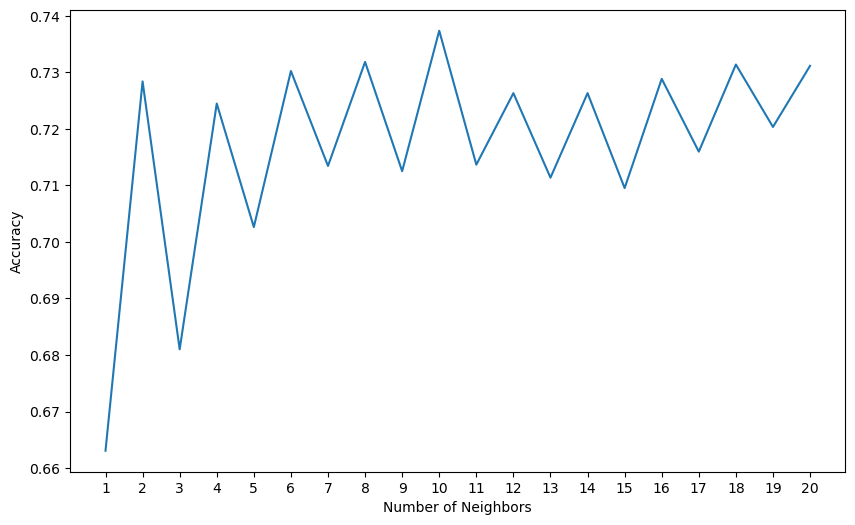

In [10]:
plt.figure(figsize = (10, 6))
plt.plot(range(1, 21), acc)
plt.xticks(np.arange(1, 21, step=1.0))
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Biểu đồ cho ta thấy độ chính xác cao nhất với giá trị của 'k' là 10

#### Xác thực siêu tham số của mô hình và báo cáo quá trình tinh chỉnh.
Để tiến hành xác thực kỹ lưỡng các siêu tham số của mô hình, nhóm đã sử dụng kỹ thuật cross-validation. Vậy cross-validation là gì?

- Cross validation là một kỹ thuật lấy mẫu để đánh giá mô hình học máy trong trường hợp dữ liệu không được dồi dào cho lắm.
- Kỹ thuật này thường bao gồm các bước như sau:
    1. Xáo trộn dataset một cách ngẫu nhiên
    2. Chia dataset thành k nhóm
    3. Với mỗi nhóm:
        - Sử dụng nhóm hiện tại để đánh giá hiệu quả mô hình
        - Các nhóm còn lại được sử dụng để huấn luyện mô hình
        - Huấn luyện mô hình
    4. Đánh giá và sau đó hủy mô hình
- Tổng hợp hiệu quả của mô hình dựa từ các số liệu đánh giá

Tiến hành tinh chỉnh siêu tham số n_neighbors của mô hình KNN

In [11]:
param_grid = {'n_neighbors':np.arange(1,50)}
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

Khớp mô hình trên tập huấn luyện rồi tìm `best_score_` và lấy siêu tham số (`best_params_`) với `best_score_`

In [12]:
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [13]:
knn_cv.best_score_

0.617022012053604

In [14]:
knn_cv.best_params_

{'n_neighbors': 48}

Khớp mô hình sau khi đã tìm được siêu tham số tốt nhất

In [15]:
knn = KNeighborsClassifier(n_neighbors = 48)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=48)

Tiến hành dự đoán

In [16]:
y_pred = knn.predict(X_test)

#### Đánh giá mô hình

Confusion Matrix

In [17]:
confusion_matrix(y_test, y_pred)

array([[3109,  406],
       [ 742,   91]], dtype=int64)

Từ Confusion Matrix ở trên, ta có:
- TP = 3503
- FP = 12
- TN = 73
- FN = 760

Classification Report

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3515
           1       0.18      0.11      0.14       833

    accuracy                           0.74      4348
   macro avg       0.50      0.50      0.49      4348
weighted avg       0.69      0.74      0.71      4348



In [19]:
scores = cross_val_score(knn_cv, X, y, cv=5)

In [20]:
print('Độ chính xác của mô hình: ', np.mean(scores))

Độ chính xác của mô hình:  0.6223116733755032


### Naive Bayes Classification
- Naive Bayes là một thuật toán học có giám sát, dựa trên định lý Bayes và được sử dụng để giải các bài toán phân loại.
- Nó chủ yếu được sử dụng trong phân loại văn bản bao gồm tập dữ liệu huấn luyện chiều cao.
- Naive Bayes Classifier là một trong những thuật toán phân lớp đơn giản và hiệu quả nhất giúp xây dựng các mô hình máy học nhanh có thể đưa ra dự đoán nhanh.
- Nó là một bộ phân loại xác suất, có nghĩa là nó dự đoán trên cơ sở xác suất của một đối tượng.
- Một số ví dụ phổ biến về thuật toán Naive Bayes là lọc thư rác, phân tích tình cảm và phân loại bài viết.

`GaussianNB()` không cần tham số nên ta tiến hành huấn luyện mô hình mà không cần kiểm tra độ chính xác đối với từng `n_neighbors` khác nhau như ở mô hình KNN.

In [21]:
nb = GaussianNB().fit(X_train, y_train)
y_pred = nb.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)
acc

0.7012419503219871

#### Xác thực siêu tham số của mô hình và báo cáo quá trình tinh chỉnh.
Ta tiến hành xác thực kỹ lưỡng siêu tham số của mô hình cũng bằng kỹ thuật cross-validation.

In [22]:
np.logspace(0,-9, num=10)

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])

In [23]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=999)

Khớp mô hình trên tập huấn luyện rồi tìm `best_score_` và lấy siêu tham số (`best_params_`) với `best_score_`

In [24]:
from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=nb, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_test)

gs_NB.fit(Data_transformed, y_test)

c:\Users\Lenovo\anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=1)

In [25]:
gs_NB.best_params_

{'var_smoothing': 0.12328467394420659}

In [26]:
gs_NB.best_score_

0.8115614459743662

In [27]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

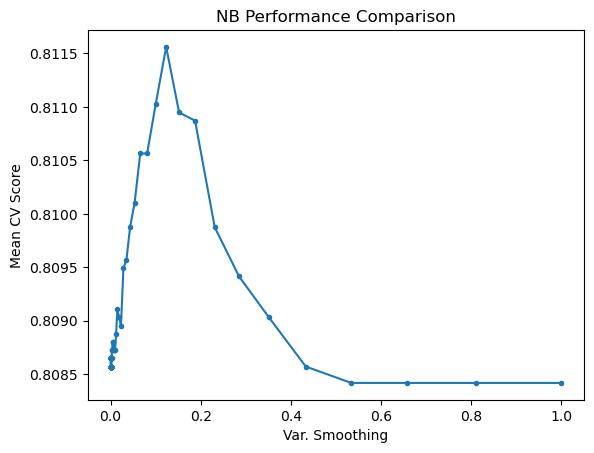

In [28]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [29]:
predict_test = gs_NB.predict(Data_transformed)

accuracy_test = metrics.accuracy_score(y_test,predict_test)
print('Độ chính xác của mô hình: ', accuracy_test)

Độ chính xác của mô hình:  0.8116375344986201
